# Stock price Prediction using LSTM network

In [1]:
#import modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
import datetime

Data='./data/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
url='drive/MyDrive/tez_datas/inf_adjusted_dataset.csv'
dataset = pd.read_csv(url, header=0, index_col=0)["Gold_Adj"]
print(dataset.values)

[ 411.88157249  412.90437249  413.10891376 ... 1508.592      1540.44292969
 1541.1552    ]


In [ ]:
# or if you don't use colab
dataset = pd.read_csv(Data + "inf_adjusted_dataset" header=0, index_col=0)["Gold_Adj"]
dataset

## Visualizing the fetched data


In [5]:
data_prediction_days=dataset.tail(365)
data_train_days=dataset[0:len(dataset)-365]


In [6]:
data_prediction_days.index=pd.to_datetime(data_prediction_days.index)
data_train_days.index=pd.to_datetime(data_train_days.index)

In [7]:
train_fold=int(len(data_train_days)*0.7)
train_fold


1864

In [10]:
validation_dataset=dataset[train_fold:data_train_days.shape[0]]

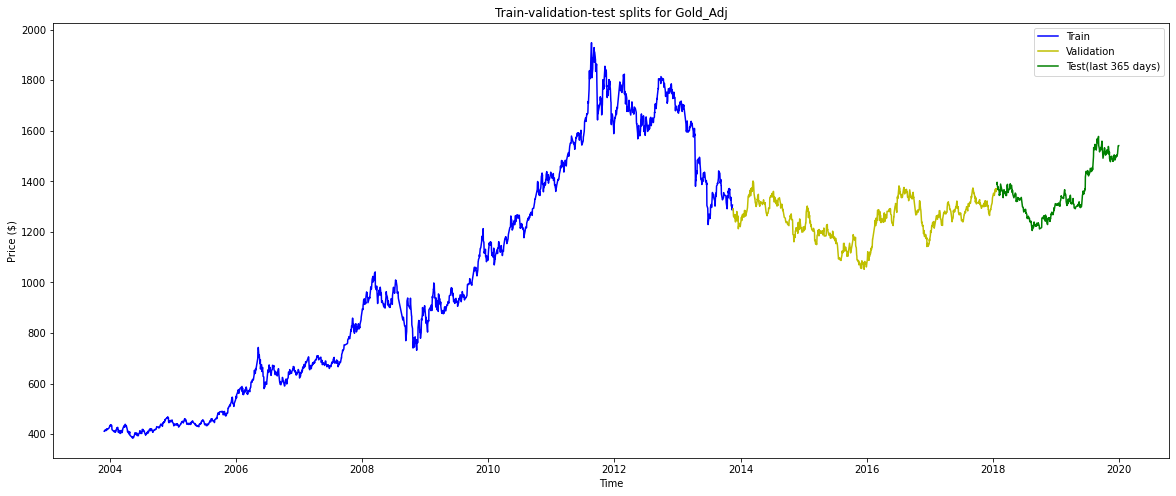

In [17]:
import matplotlib.dates as mdates
figs=plt.figure(figsize=(20,8))
ax=figs.add_subplot()
ax.plot(data_train_days[0:train_fold],c='b',label='Train')
ax.plot(data_train_days[train_fold:],c='y',label='Validation')
ax.plot(data_prediction_days,c='g',label='Test(last 365 days)')

plt.title('Train-validation-test splits for %s'% dataset.name)
plt.xlabel('Time')
plt.ylabel('Price ($)')

plt.legend()
plt.show() 

## Create train sets with applicable shape

In [18]:
sc = MinMaxScaler(feature_range = (0, 1))

def create_datasets(train_set,lb):
  dataset_scaled = sc.fit_transform(train_set)
  X_train = []
  y_train = []
 

  for x in range(lb, len(dataset_scaled)):
      X_train.append(dataset_scaled[x - lb:x,0])
      y_train.append(dataset_scaled[x, 0])
  
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  return X_train,y_train


In [62]:
data_train=pd.DataFrame(data_train_days)
data_test=pd.DataFrame(data_prediction_days)
lb=30
train_set = data_train
X_train,y_train=create_datasets(train_set,lb)


In [63]:
X_train.shape

(2633, 30, 1)

In [64]:
data_valid=pd.DataFrame(validation_dataset)
X_valid,y_valid=create_datasets(data_valid,lb)

In [65]:
X_valid.shape

(769, 30, 1)

In [73]:
from keras.utils.vis_utils import plot_model


#Defining the LSTM Recurrent Mode
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True,input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True,show_layer_names=True,expand_nested=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 30, 50)            10400     
                                                                 
 dropout_20 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_21 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_21 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_22 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_22 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_23 (LSTM)              (None, 50)               

In [74]:
#Compiling and fitting the model
model.compile(optimizer = 'adam', loss ='mean_squared_error')
history=model.fit(X_train, y_train ,validation_data=(X_valid,y_valid),epochs = 20, batch_size = 32)

Epoch 1/20
83/83 [==============================] - 9s 52ms/step - loss: 0.0178 - val_loss: 0.0140
Epoch 2/20
83/83 [==============================] - 3s 38ms/step - loss: 0.0040 - val_loss: 0.0137
Epoch 3/20
83/83 [==============================] - 3s 38ms/step - loss: 0.0036 - val_loss: 0.0146
Epoch 4/20
83/83 [==============================] - 3s 38ms/step - loss: 0.0030 - val_loss: 0.0127
Epoch 5/20
83/83 [==============================] - 3s 38ms/step - loss: 0.0033 - val_loss: 0.0129
Epoch 6/20
83/83 [==============================] - 3s 38ms/step - loss: 0.0028 - val_loss: 0.0124
Epoch 7/20
83/83 [==============================] - 3s 39ms/step - loss: 0.0025 - val_loss: 0.0117
Epoch 8/20
83/83 [==============================] - 4s 43ms/step - loss: 0.0026 - val_loss: 0.0124
Epoch 9/20
83/83 [==============================] - 3s 39ms/step - loss: 0.0024 - val_loss: 0.0114
Epoch 10/20
83/83 [==============================] - 3s 39ms/step - loss: 0.0025 - val_loss: 0.0110
Epoch 11/

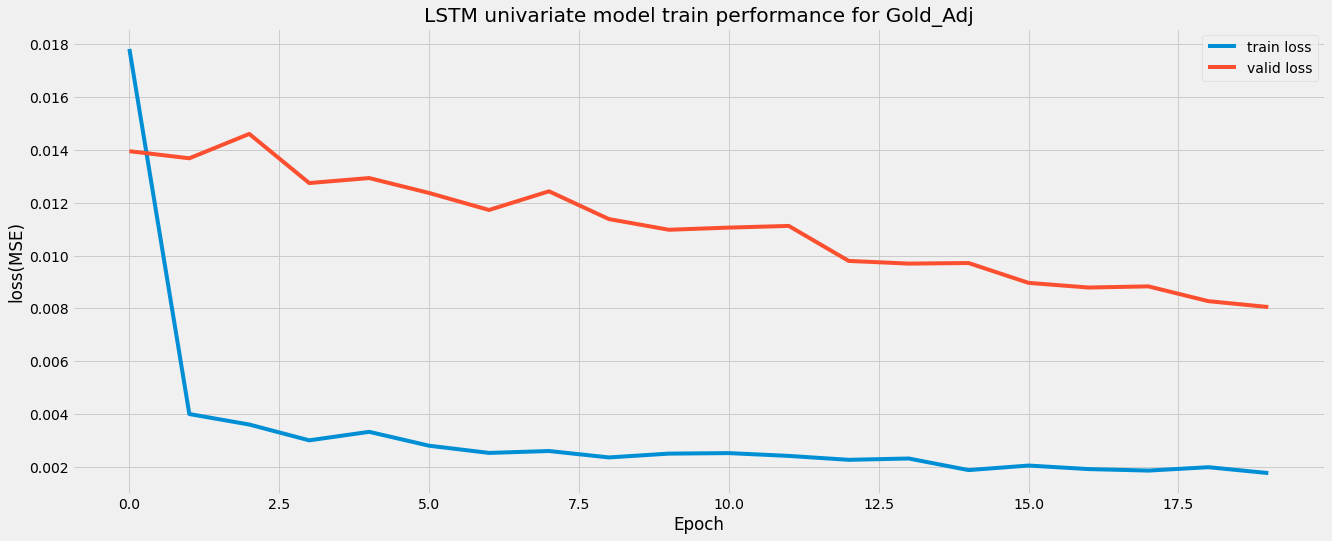

In [75]:
plt.figure(figsize=(20,8))
plt.style.use('fivethirtyeight')

plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'],  label = 'valid loss')
plt.title('LSTM univariate model train performance for %s' %dataset.name)
plt.xlabel('Epoch')
plt.ylabel('loss(MSE)')
plt.legend()
plt.show()

In [76]:
#testdata=pd.DataFrame(data_prediction_days)
real_stock_price = data_prediction_days
dataset_total = pd.concat((data_train, data_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(data_test) - lb:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test=[]
for i in range(lb, len(inputs)):
    X_test.append(inputs[i-lb:i, 0])
    #y_test.append(inputs[i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)


(365, 30, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [77]:
predicted_price = model.predict(X_test)
predicted_price = sc.inverse_transform(predicted_price)

## Evaluate metrics

In [78]:
from cmath import sqrt

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
r2=r2_score(real_stock_price,predicted_price) 
rmse=sqrt(mean_squared_error(real_stock_price,predicted_price))/(max(real_stock_price)-min(real_stock_price))
mae=mean_absolute_error(real_stock_price,predicted_price)
print("RMSE: %s r2 score: %.5f, mae score : %.5f" % (rmse,r2,mae))

RMSE: (0.07007189487225349+0j) r2 score: 0.92823, mae score : 19.84140


## Accuracy calculalation 
### (if prediction is greater than %20 of real value)

In [79]:
percent=0.2
vector=[]
for i in range(0,predicted_price.shape[0]):
    if abs(predicted_price[i] - real_stock_price[i]) < real_stock_price[i]*percent:
        vector.append(True)
    else:
        vector.append(False)
print("Accuracy: %" ,vector.count(True)/len(vector)*100)

Accuracy: % 100.0


## predictions & real stocs

In [80]:
predicted_price=np.squeeze(predicted_price)
real_stock_price=np.squeeze(real_stock_price)
df=pd.DataFrame({
    "pred":predicted_price,
    "real":real_stock_price,
    

})
df["% diff"]=(abs(df["pred"]-df["real"])/df["real"])*100
df
#print(df["% diff"].mean())

,pred,real,% diff
Date,,,
2018-01-24,1353.513916,1389.661935,2.601210
2018-01-25,1356.171387,1396.323785,2.875579
2018-01-26,1358.933838,1385.254815,1.900082
2018-01-30,1361.832520,1368.651485,0.498225
2018-01-31,1364.559692,1372.341100,0.567017
...,...,...,...
2019-12-19,1475.601929,1504.216270,1.902276
2019-12-20,1476.420166,1500.654670,1.614929
2019-12-23,1477.286255,1508.592000,2.075163


In [81]:
predicted=pd.DataFrame(predicted_price,index=real_stock_price.index)

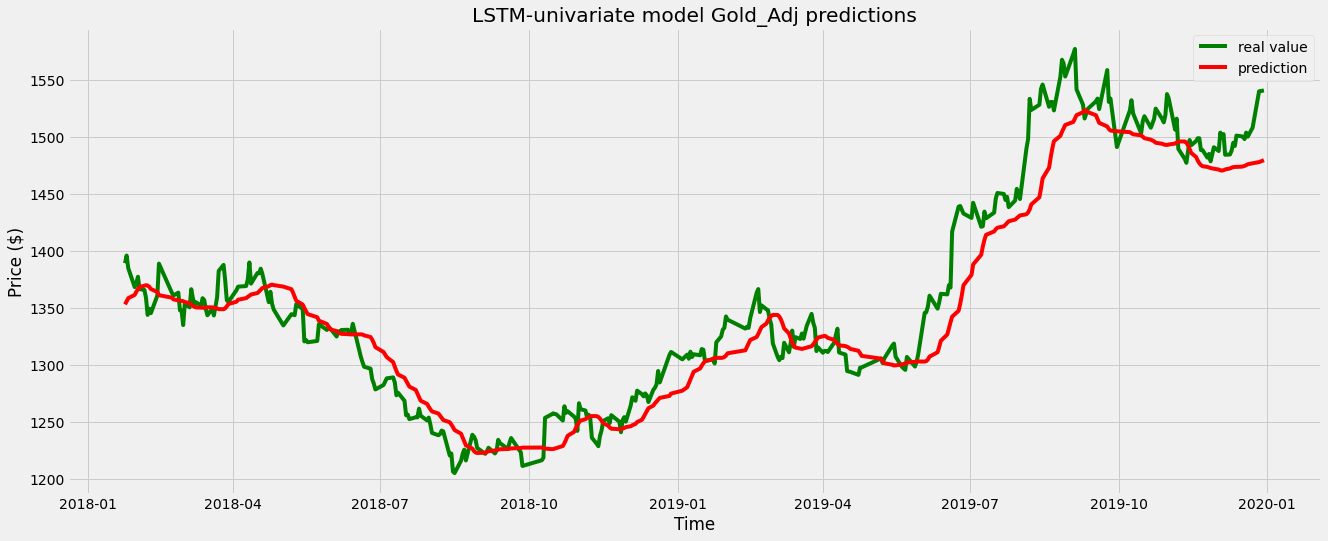

In [82]:
#Visualizing the prediction
plt.figure(figsize=(20,8))
plt.plot(real_stock_price, color = 'green', label = 'real value')
plt.plot(predicted, color = 'red', label = 'prediction')
plt.title('LSTM-univariate model %s predictions' %dataset.name) 
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.show()